In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
classes = Base.classes.keys()

print("Automap found the following classes:")
for names in classes:
    print(names)

Automap found the following classes:
measurement
station


In [8]:
# Save references to each table
station = Base.classes.station
measure = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(measure.date).order_by(measure.date.desc()).first()
print(recent_date)

('2017-08-23',)


<Figure size 720x432 with 0 Axes>

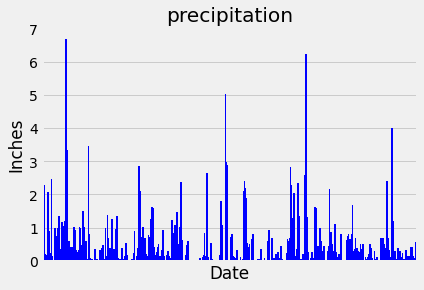

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
#change recent_date from above from a string into recent_date_date
from datetime import datetime
from datetime import timedelta

date_string = '2017-08-23'
date_format = '%Y-%m-%d'
recent_date_date = datetime.strptime(date_string, date_format)


# Calculate the date one year from the last date in data set.
recent_date_minus_one_year_ago = recent_date_date - timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
last_years_precipitation = (
    session.query(measure.date, measure.prcp)
    .filter(measure.date >= recent_date_minus_one_year_ago)
    .order_by(measure.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_years_precipitation_df = pd.DataFrame(last_years_precipitation, columns=['date','prcp'])

# Sort the dataframe by date
last_years_precipitation_df_sorted = last_years_precipitation_df.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10, 6))
last_years_precipitation_df_sorted.plot(x='date', y='prcp', kind='bar', width=10, color='blue', legend=False)
plt.title('precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks([])
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = last_years_precipitation_df_sorted['prcp'].describe()
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count('*')).select_from(station).scalar()
print(station_count)


9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
total_observations = session.query(measure.station, func.count('*').label('row_count')).group_by(measure.station).all()
total_observations_orderred = sorted(total_observations, key=lambda x: x.row_count, reverse=True)
total_observations_orderred

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

lowest_temp = (
    session.query(func.min(measure.tobs))
    .filter(measure.station == most_active_station_id)
    .scalar()
)

highest_temp = (
    session.query(func.max(measure.tobs))
    .filter(measure.station == most_active_station_id)
    .scalar()
)

avg_temp = (
    session.query(func.avg(measure.tobs))
    .filter(measure.station == most_active_station_id)
    .scalar()
)

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_most_recent_date = session.query(func.max(measure.date)).filter(measure.station == most_active_station_id).scalar()
print(most_active_station_most_recent_date)

2017-08-18


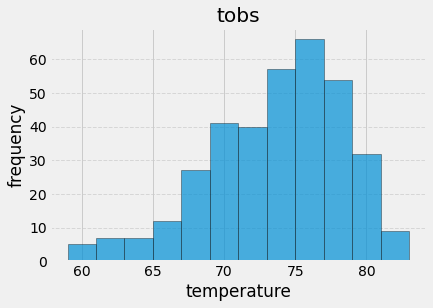

In [16]:
most_active_station_temperature_results = (
    session.query(measure.date, measure.tobs)
    .filter(measure.station == most_active_station_id)
    .filter(measure.date >= '2016-08-18')
    .all()
)

most_active_station_temperature_df = pd.DataFrame(most_active_station_temperature_results, columns=['date', 'tobs'])

plt.figure()
plt.hist(most_active_station_temperature_df['tobs'], bins=12, edgecolor='black', alpha=0.7)
plt.title('tobs')
plt.xlabel('temperature')
plt.ylabel('frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Close Session

In [21]:
# Close Session
session.close()